### Configuración del entorno

Descarga de Libreria Grounding Dino

In [1]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 463 (delta 176), reused 137 (delta 137), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [2]:
%cd GroundingDINO/

/content/GroundingDINO


In [3]:
!pip install -e .

Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 15.5 MB/s eta 0:00:00
  Running setup.py develop for groundingdino


In [4]:
!pip install supervision


In [5]:
%cd ..

/content


In [6]:
%mkdir weights

In [7]:
%cd weights

/content/weights


In [8]:
!pwd

/content/weights


In [9]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth


Reinicia el kernell de colab

In [10]:
exit()

In [1]:
!pwd

/content


Instalar modelo SAM

In [2]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-e1965krv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-e1965krv
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=f5d08e9d1b0a81406ad1cf782473a45427b085dfbcbc2149f61d7aa4a760075e
  Stored in directory: /tmp/pip-ephem-wheel-cache-oigu9ly9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [3]:
!pip install -q roboflow supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00


In [4]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

In [5]:
## opcional para reiniciar el kernell
exit()

## Uso de los Modelos

Instalar librerias necesarias

In [4]:
import os
import cv2
import json
import numpy as np
import random
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

Descarga de Dataset de Kaggle

In [5]:
# Download latest version
path = kagglehub.dataset_download("siddharthkumarsah/plastic-bottles-image-dataset")

Se genera una muestra de 100 imagenes para trabajar

In [6]:
num_muestras= 100
complete_path_train = path + "/Plastic Bottle Image Dataset/train/images"

# Obtener una lista de todos los archivos en la carpeta (asegúrate de que son imágenes)
all_images = [file for file in os.listdir(complete_path_train) if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

# Filtrar imágenes con dimensiones mayores a 128x128
filtered_images = []
for file in all_images:
    file_path = os.path.join(complete_path_train, file)
    try:
        img = load_img(file_path)  # Carga la imagen
        width, height = img.size  # Obtiene las dimensiones
        if width > 128 and height > 128:
            filtered_images.append((file_path, width, height))  # Agrega la ruta, ancho y alto como tupla
    except Exception as e:
        print(f"Error al procesar {file}: {e}")

# Seleccionar 100 imágenes al azar
subset_images = random.sample(filtered_images, num_muestras)


In [7]:
# Ruta completa de las imágenes seleccionadas
subset_paths = [os.path.join(complete_path_train, img[0]) for img in subset_images]
new_paths= []
os.makedirs("./images", exist_ok=True)


for source_path in subset_paths:
    # Obtener el nombre del archivo
    file_name = os.path.basename(source_path)
    # Construir el path destino
    destination_path = os.path.join("./images", file_name)
    # Mover archivo
    os.rename(source_path, destination_path)
    new_paths.append(destination_path)

subset_paths = new_paths


Se hace el resize de las imagenes al tamaño de la mas pequeña del conjunto de datos

In [8]:
output_folder = "./resized_images"
os.makedirs(output_folder, exist_ok=True)

# Determinar el tamaño mínimo
min_width, min_height = float('inf'), float('inf')
for path in subset_paths:
    try:
        img = load_img(path)
        width, height = img.size
        min_width = min(min_width, width)
        min_height = min(min_height, height)
    except Exception as e:
        print(f"Error al procesar {path}: {e}")

print(f"Tamaño mínimo encontrado: {min_width}x{min_height}")

# Redimensionar y guardar imágenes
for path in subset_paths:
    try:
        img = load_img(path)  # Cargar imagen
        img_array = img_to_array(img)  # Convertir a array
        resized_img_array = tf.image.resize(img_array, (min_height, min_width))  # Redimensionar
        resized_img_array = tf.cast(resized_img_array, dtype=tf.uint8)  # Convertir a enteros de 8 bits
        output_path = os.path.join(output_folder, os.path.basename(path))  # Ruta de salida
        save_img(output_path, resized_img_array)  # Guardar imagen redimensionada
        #print(f"Guardada: {output_path}")
    except Exception as e:
        print(f"Error al redimensionar {path}: {e}")

Tamaño mínimo encontrado: 200x150


Instala esto de groundigdino

In [9]:
from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model("/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
     "weights/groundingdino_swint_ogc.pth")

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


In [10]:
import torch
from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
print(DEVICE)
sam = sam_model_registry[MODEL_TYPE](checkpoint="./sam_vit_h_4b8939.pth")
sam.to(device=DEVICE)

cuda:0


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

y se realiza la deteccion usando GroundingDino

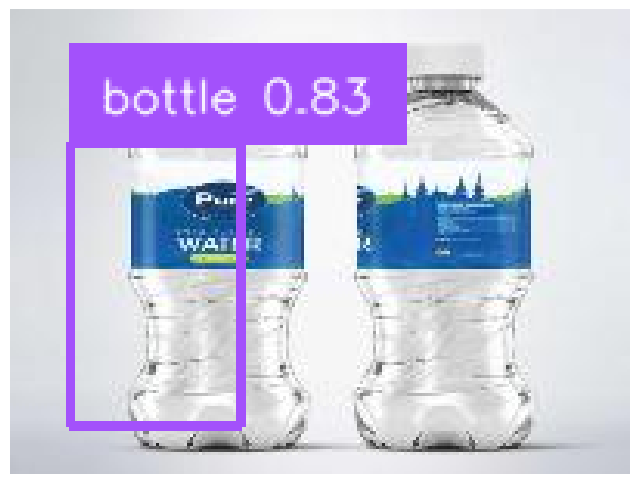

Escribiendo etiqueta: 0.00127759191673249 0.00398513488471508 0.00020079359819646925 5.2410363423405215e-05


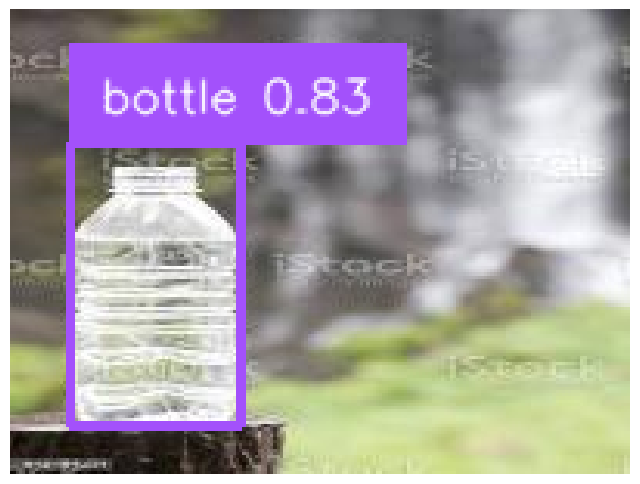

Escribiendo etiqueta: 0.00127759191673249 0.00398513488471508 0.00020079359819646925 5.2410363423405215e-05


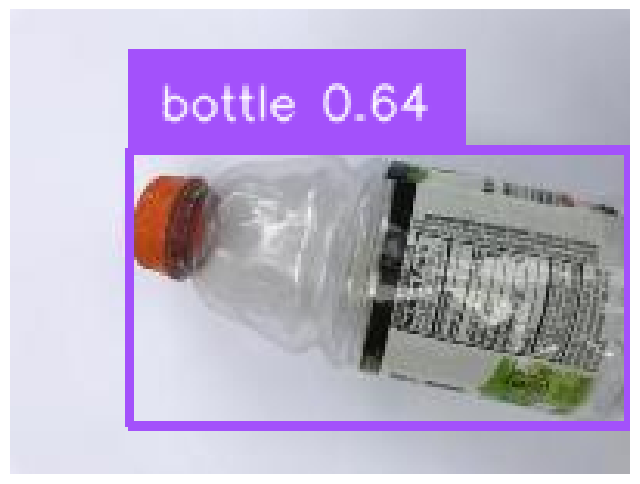

Escribiendo etiqueta: 0.0035071626771241426 0.0039598941802978516 0.0010447138920426369 -7.933974120533094e-05


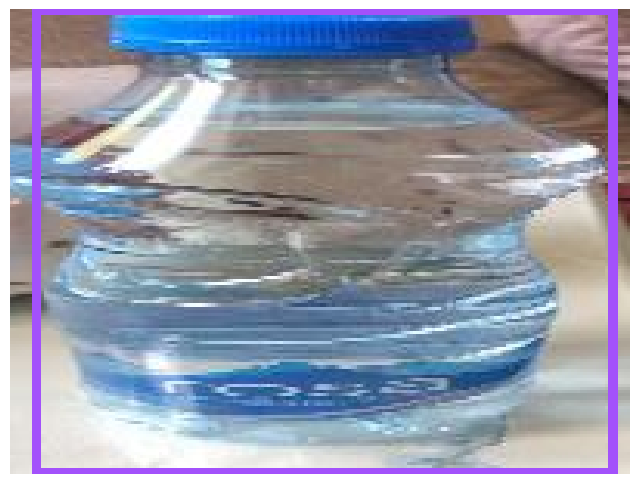

Escribiendo etiqueta: 0.0035944574046880007 0.004990554414689541 0.0021200645714998245 0.0033265931997448206


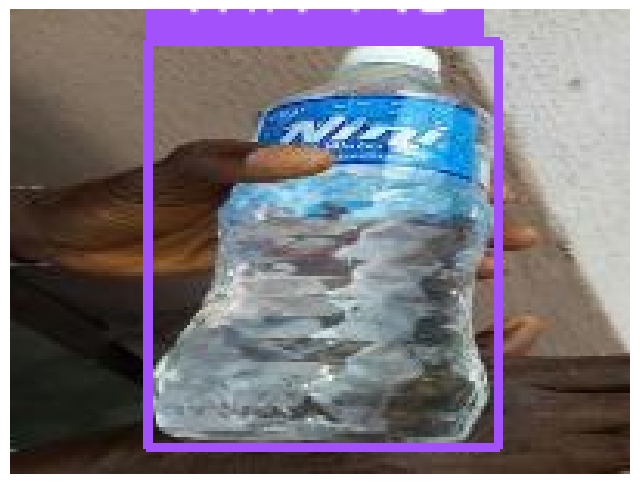

Escribiendo etiqueta: 0.0026820367202162743 0.00460434565320611 0.0003028655191883445 0.002456950256600976


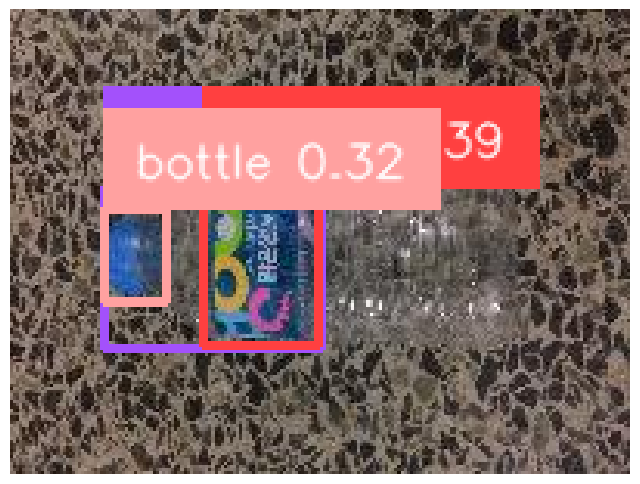

Escribiendo etiqueta: 0.00169512745924294 0.0030082741286605597 9.923428297042847e-05 -0.001409544376656413
Escribiendo etiqueta: 0.0014802203513681889 0.002977345371618867 -0.0011107000755146146 -0.0014521307311952114
Escribiendo etiqueta: 0.0007595101487822831 0.002451887121424079 -0.0005177623243071139 -0.002171796280890703


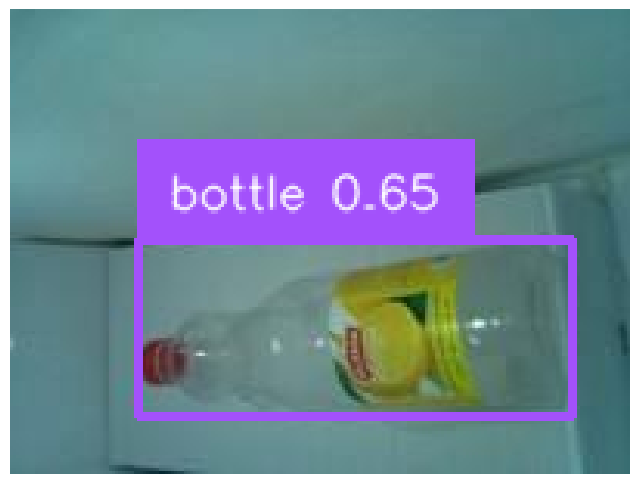

Escribiendo etiqueta: 0.003148272866383195 0.003535433206707239 0.00072144326986745 -0.0020775627344846725


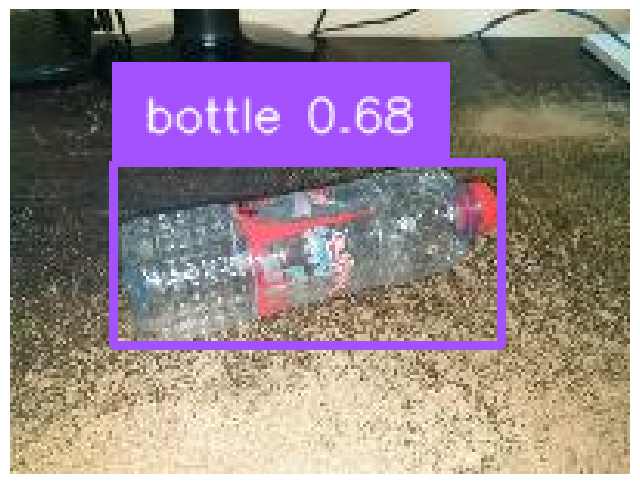

Escribiendo etiqueta: 0.0027679733466356993 0.0030811538454145193 0.0007303808815777302 -0.0008567559998482466


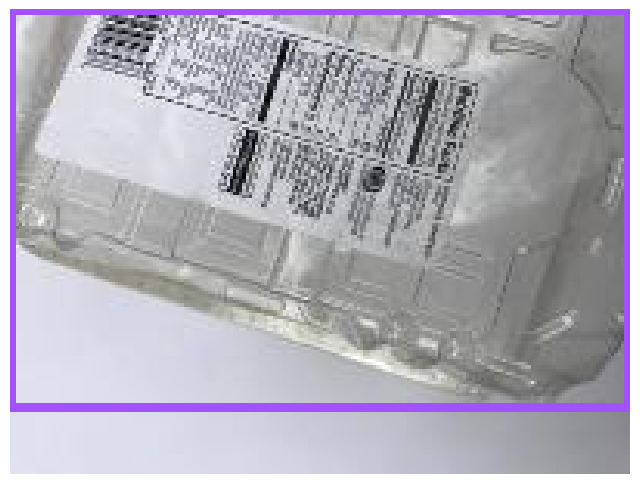

Escribiendo etiqueta: 0.0037499088793992996 0.004270977806299925 0.0025001787580549717 0.002853171434253454


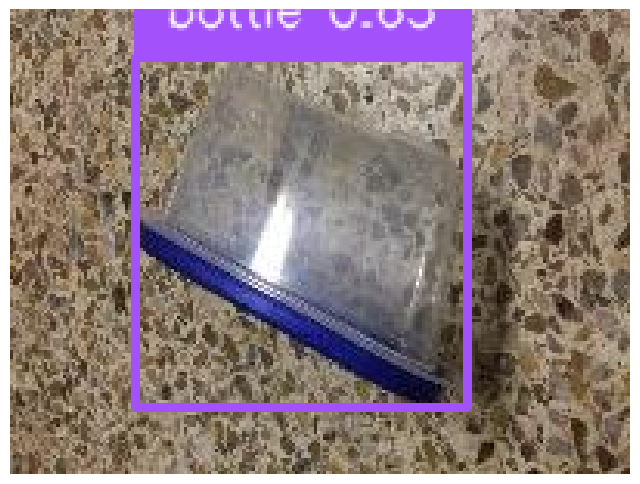

Escribiendo etiqueta: 0.002518594963476062 0.004100118763744831 0.00034066991065628827 0.0018004006706178188


KeyboardInterrupt: 

In [17]:
import os
import supervision as sv
import matplotlib.pyplot as plt
import numpy as np
from segment_anything import SamPredictor, sam_model_registry  # Importar SAM (ajustar según tu implementación)
import torch

text="Bottle"#"T-Shirt Shirt Sweater Hoodie Jacket"
BOX_THRESHOLD = 0.26
TEXT_TRHESHOLD = 0.30

sam_predictor = SamPredictor(sam)

# Directorios de salida
detections_dir = "/content/detections"
images_dir = os.path.join(detections_dir, "images")
labels_dir = os.path.join(detections_dir, "labels")

# Crear los directorios si no existen
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Suponiendo que las clases ya están definidas
def save_detection_yolo(image_path, annotated_frame, boxes, phrases, image_width, image_height):
    # Generar nombre para la imagen y el archivo de etiqueta
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    # Guardar la imagen anotada
    annotated_image_path = os.path.join(images_dir, f"{base_name}_annotated.jpg")
    save_img(annotated_image_path, annotated_frame)

    # Crear las etiquetas en formato YOLO
    label_path = os.path.join(labels_dir, f"{base_name}_labels.txt")

    # Comprobamos si hay cajas para escribir
    if len(boxes) > 0:
        with open(label_path, 'w') as label_file:
            for box, phrase in zip(boxes, phrases):
              # Normalizar las coordenadas de la caja
              x_min, y_min, x_max, y_max = box
              x_center = (x_min + x_max) / 2 / image_width
              y_center = (y_min + y_max) / 2 / image_height
              width = (x_max - x_min) / image_width
              height = (y_max - y_min) / image_height
              print(f"Escribiendo etiqueta: {x_center} {y_center} {width} {height}")

              # Escribir la línea en el archivo de etiquetas
              label_file.write(f"0 {x_center} {y_center} {width} {height}\n")
    else:
        print(f"No se encontraron cajas para la imagen {base_name}, no se escribió el archivo de etiquetas.")

# Iterar sobre los paths de las imágenes
for path in subset_paths:
    # Preparar la ruta de la imagen original
    image_path = path.replace('images', 'resized_images')

    # Cargar la imagen y hacer la predicción
    image_source, image = load_image(image_path)
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=text,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_TRHESHOLD,
        device='cpu'  # Cambiar a 'cuda' si tienes GPU disponible
    )

    # Obtener las dimensiones de la imagen
    image_height, image_width, _ = image_source.shape

    # Anotar la imagen
    annotated_frame = annotate(
        image_source=image_source,
        boxes=boxes,
        logits=logits,
        phrases=phrases
    )

    # Mostrar la imagen anotada
    sv.plot_image(annotated_frame, (8, 8))

    # Guardar imagen y etiquetas
    save_detection_yolo(image_path, annotated_frame, boxes, phrases, image_width, image_height)

In [20]:
def process_labels_and_segment(image_path, image_source, label_path, sam_predictor):
    # Cargar las etiquetas desde el archivo
    with open(label_path, 'r') as label_file:
        label_lines = label_file.readlines()

    # Extraer las coordenadas de las cajas (normalizadas) y las clases
    boxes = []
    phrases = []  # Puedes agregar un mapeo de clases si es necesario
    for line in label_lines:
        elements = line.strip().split()  # Dividir por espacios
        if len(elements) < 5:  # Asegurarse de que la línea esté bien formada
            continue
        class_id = int(elements[0])
        x_center = float(elements[1])
        y_center = float(elements[2])
        width = float(elements[3])
        height = float(elements[4])

        # Convertir las coordenadas normalizadas a píxeles
        x_min = int((x_center - width / 2) * image_source.shape[1])
        y_min = int((y_center - height / 2) * image_source.shape[0])
        x_max = int((x_center + width / 2) * image_source.shape[1])
        y_max = int((y_center + height / 2) * image_source.shape[0])

        # Almacenar la caja y el texto de referencia (puedes añadir más lógica aquí)
        boxes.append([x_min, y_min, x_max, y_max])
        phrases.append(f"Class {class_id}")  # Cambiar según el uso que des a las clases

    # Crear una copia de la imagen para mostrar las segmentaciones
    segmented_image = np.copy(image_source)

    # Procesar cada caja para segmentar solo dentro de esa área
    for box, phrase in zip(boxes, phrases):
        # Extraer la región de la imagen correspondiente a la caja
        x_min, y_min, x_max, y_max = box
        object_region = image_source[y_min:y_max, x_min:x_max]  # Recortar la región

        # Calcular el centro de la caja (para pasarle a SAM)
        x_center_pixel = (x_min + x_max) // 2
        y_center_pixel = (y_min + y_max) // 2

        # Definir el punto de inicio para la segmentación (centro del objeto)
        point = np.array([[y_center_pixel, x_center_pixel]])  # Formato (y, x) -> coordenadas de píxel

        # Realizar la segmentación con SAM solo en la región definida por la caja
        sam_predictor.set_image(image_source)
        masks, _, _ = sam_predictor.predict(point_coords=point, point_labels=np.array([1]), multimask_output=False)

        # Redimensionar la máscara a las dimensiones de la región recortada
        mask_resized = masks[0][y_min:y_max, x_min:x_max]  # Recortar la máscara para la región seleccionada

        # Verificar las dimensiones antes de aplicar la máscara
        if mask_resized.shape == object_region.shape[:2]:
            # Aplicar la segmentación a la imagen (solo en la región seleccionada)
            segmented_image[y_min:y_max, x_min:x_max][mask_resized == 1] = [255, 0, 0]  # Colorear la región segmentada en rojo
        else:
            print(f"Advertencia: la máscara y la región no coinciden en dimensiones. Región: {object_region.shape}, Máscara: {mask_resized.shape}")

        # Mostrar la imagen con la segmentación aplicada
        plt.figure(figsize=(10, 10))
        plt.imshow(segmented_image)
        plt.title(f"Segmentación para {phrase}")
        plt.axis('off')
        plt.show()

path_labels = "/content/detections/labels"
sam_predictor = SamPredictor(sam)
for path in subset_paths:
    # Preparar la ruta de la imagen original
    image_path = path.replace('images', 'detections/images')

    total_path = image_path + "/images"
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    path_labels = os.path.join(path_labels, f"{base_name}_labels.txt")
    image_source, image = load_image(image_path)
    process_labels_and_segment(image_path, image_source, path_labels, sam_predictor)

    # Cargar la imagen y las etiquetas
    image_source, image = load_image(image_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/detections/images/0ca7ac8a475b64ebce575799fffb8c6c_png.rf.ee9bd18643dee88fc258ba975d457a45.jpg'